In [1]:
# Import packages
import sys 
import glob
import numpy as np
import iris
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import iris.plot as iplt
from iris.time import PartialDateTime 
import pandas as pd
import warnings
import cartopy.crs as ccrs
from pyproj import Transformer
import iris.coord_categorisation
import datetime
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# # Stops warning on loading Iris cubes
# iris.FUTURE.netcdf_promote = True
# iris.FUTURE.netcdf_no_unlimited = True

# Provide root_fp as argument
root_fp = "/nfs/a319/gy17m2a/"
# root_fp = 'C:/Users/gy17m2a/'
os.chdir(root_fp)

sys.path.insert(0, root_fp + 'PhD/Scripts/GlobalFunctions')
from Obs_functions import *
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

# Define name and coordinates of location
# Read in shapefile 
lindyke_shp = gpd.read_file("PhD/FloodModelling/IndividualCatchments/LinDyke/Shapefile/FEH_Catchment_443550_427250.shp")
lindyke_shp =  lindyke_shp.to_crs({'init' :'epsg:3857'})  

### Load in spatial data
As geodataframes for plotting
As shapely geometries for checking whether lat/long points are within the areas

In [2]:
# This is the outline of Leeds
leeds_gdf = create_leeds_outline({'init' :'epsg:3857'})
# This is a square area surrounding Leeds
leeds_at_centre_gdf = create_leeds_at_centre_outline({'init' :'epsg:3857'})

### Load in the reformatted observations cubes and concatenate into one cube

In [3]:
filenames =[]
# Create filepath to correct folder using ensemble member and year
general_filename = 'PhD/datadir/CEH-GEAR/CEH-GEAR_reformatted/rf_*'
# Find all files in directory which start with this string
for filename in glob.glob(general_filename):
    #print(filename)
    filenames.append(filename)
# Load all cubes into list
monthly_cubes_list = iris.load(filenames,'rainfall_amount')

# Concatenate the cubes into one
concat_cube = monthly_cubes_list.concatenate_cube()

# Test plotting
# iplt.pcolormesh(concat_cube[12])

### Trim concatenated cube to outline of leeds-at-centre geodataframe

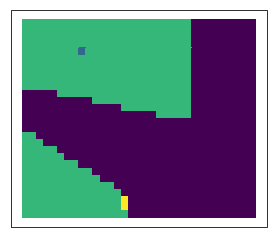

In [4]:
concat_cube = trim_to_bbox_of_region_obs(concat_cube, leeds_gdf)

# Test plotting
iplt.pcolormesh(concat_cube[12])

# fig = plt.figure(figsize = (20,30))
# proj = ccrs.Mercator.GOOGLE
# ax = fig.add_subplot(projection=proj)
# mesh = iplt.pcolormesh(concat_cube[12], cmap = 'Blues')
# leeds_gdf.plot(ax=ax, edgecolor='black', color='none', linewidth=4)

### Cut to just June-July_August period


In [ ]:
# ## Add season variables
# iris.coord_categorisation.add_season(concat_cube,'time', name = "clim_season")

# # Keep only JJA
# jja_cube = concat_cube.extract(iris.Constraint(clim_season = 'jja'))

Check each lat/long combination (central point of grid cell) as to whether it is within the catchment
If it is, then add its data to an array which will store the values for all cells within the catchment

Also, check location of cells for which data is extracted
Create a 2D array, with same shape as cube for one timeslice
Set all values to 0 initially, and then for grid cells from which data is extracted set the value to 1

In [ ]:
# For use in for loop:
# Create variables specifying the number of lat and long values there are 
lat_length, lon_length = concat_cube.shape[1], concat_cube.shape[2]
# Store lat and long values as variables
lats = concat_cube.coord('projection_y_coordinate').points
lons = concat_cube.coord('projection_x_coordinate').points

# Get times
times = concat_cube.coord('time').points
# Convert to datetimes
times = [datetime.datetime.fromtimestamp(x).strftime("%x %X") for x in times]
times= [datetime.datetime.strptime(x, '%m/%d/%y %H:%M:%S') for x in times]
# Save data for all of Lin Dyke
np.save("PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/DeriveAntecedentConditions/LinDykeRainfall/wholeyear/times.npy", times)

# Create a list to store the indices of the coordinates within the catchment
coords_within_catchment_ls = []
# Create an empty array to store the data
all_the_data = np. array([])

counter = 0 
# Loop through each lat/long pair 
for i in range(0,lat_length): 
    for j in range(0,lon_length):
        # Transform this lat/long pair into Web Mercator, and create a Shapely point
        transformer = Transformer.from_crs("epsg:27700", "epsg:3857")
        x, y = transformer.transform(lons[j], lats[i])
        point = Point(x,y) 
        # Check if point is within catchment boundary shapefile
        if lindyke_shp.contains(point)[0]:
            # print to show progress
            print(i,j)
            if counter > 12:
                print(i,j)
                # Get data for this one slice
                one_slice = concat_cube[:,i,j].data
                # Unmask array
                one_slice = one_slice.data
                # Add to array contianing data for all of cells in catchment
                all_the_data = np.append(all_the_data, one_slice)
                # Store the indices of the lat/longs with the catchment (for plotting) 
                coords_within_catchment_ls.append((i, j)) 
                # Save one slice of data
                np.save("PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/DeriveAntecedentConditions/LinDykeRainfall/wholeyear/{}_{}.npy".format(i,j), one_slice)
            counter = counter +1
# # Save data for all of Lin Dyke
# np.save("PhD/Scripts/CatchmentAnalysis/CreateSyntheticRainfallEvents/DeriveAntecedentConditions/LinDykeRainfall/wholeyear/LinDyke.npy", all_the_data)


17 24
17 25
17 26
17 27
17 28
18 25
18 26
18 27
19 26
19 27
19 28
20 26
20 27
20 28
20 28
20 29
20 29
